### Import modules

In [213]:
from datetime import datetime
import fiona
import geopandas as gpd
import glob
import imageio
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import os
import pandas as pd
from pyproj import CRS
import rasterio
import rasterio.mask
from rasterio.mask import mask
from rasterio import plot as rasterplot
from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.enums import ColorInterp
from rasterio.enums import Resampling
from shapely.geometry import mapping
from xml.dom import minidom


### Set variables

In [214]:
# Planet images (seperate folder)
base_dir = r"C:\Local_Python\241381_Ballangary_Analysis\Product\Input Waterbody\20231118-20231204_NSN"
image_files = glob.glob(os.path.join(base_dir, "*AnalyticMS_SR_clip.tif"))
xml_files = glob.glob(os.path.join(base_dir, "*AnalyticMS_metadata_clip.xml"))

# print(fileList_XML)
# print (fileList)

# Waterbody crest shapefile
waterbody = r"C:\Local_Python\241381_Ballangary_Analysis\Product\Input Waterbody\Waterbody.shp"

# Output table
csv = r'C:\Local_Python\241381_Ballangary_Analysis\Product\Output Waterbody\Fix - 20231118-20231204\Fix - 20231118-20231204_Planet_Timeseries_Waterbody_NDWI.csv'

# Output raster
folder = r'C:\Local_Python\241381_Ballangary_Analysis\Product\Output Waterbody\Fix - 20231118-20231204'

# NDWI threshold value
threshold = 0

### Declare functions

In [215]:
def create_ndwi_4b(clip, output):

        # Load green and NIR bands - changed for 8 band
        with rasterio.open(clip) as src:
            band_grn = src.read(2).astype(float) # read floating point values
            band_nir = src.read(4).astype(float) # read floating point values

        # Allow division by zero
        np.seterr(divide='ignore', invalid='ignore')

        # Calculate NDWI. This is the equation at the top of this guide expressed in code
        ndwi = (band_grn - band_nir) / (band_grn + band_nir)
        
        # Set spatial characteristics of the output object to mirror the input
        kwargs = src.meta
        kwargs.update(
        dtype=rasterio.float32,
        count = 1)

        # Write band calculations to a new raster file (values over 0)
        with rasterio.open(output, 'w', **kwargs) as dst:
                dst.write_band(1, ndwi.astype(rasterio.float32))# Function to clip raster to shapefile
                
def clip_raster_to_shapefile(raster_file, shapefile, output_file):
    
    # Open shapefile using geopandas
    shp = gpd.read_file(shapefile)
    
    # Open raster file using rasterio
    with rasterio.open(raster_file) as src:
        # shp=shp.to_crs(src.crs)
        # print(Vector.crs)
        out_image, out_transform=mask(src,shp.geometry,crop=True)
        out_meta=src.meta.copy() # copy the metadata of the source DEM

    out_meta.update({
        "driver":"Gtiff",
        "height":out_image.shape[1], # height starts with shape[1]
        "width":out_image.shape[2], # width starts with shape[2]
        "transform":out_transform
    })

    with rasterio.open(output_file,'w',**out_meta) as dst:
        dst.write(out_image)    
    
# Function to classify raster into two classes based on a threshold
def classify_raster(raster_file, threshold, output_file):
    with rasterio.open(raster_file) as src:
        # Read raster band 1
        band1 = src.read(1)

        # Apply classification based on threshold
        classified = np.where(band1 > threshold, 0, 1)

        # Update metadata
        out_meta = src.meta.copy()

    # Write the classified raster to a new file
    with rasterio.open(output_file, "w", **out_meta) as dest:
        dest.write(classified, 1)

# Function to measure the area of the raster above the threshold
def measure_area_above_threshold(raster_file, threshold):
    with rasterio.open(raster_file) as src:
        # Read raster band 1
        band1 = src.read(1)

        # Apply classification based on threshold
        classified = np.where(band1 > threshold, 1, 0)
        #print ("classified ", classified)
        # Identify NoData values
        nodata = src.nodata

        # Exclude NoData values from calculation
        valid_values = np.logical_not(np.isnan(band1)) & np.logical_not(np.isclose(band1, nodata))
        #print ("valid_values", valid_values)
        # Calculate the area of cells above the threshold
        transform = src.transform
        #print ("transform ", transform)

        # Get the cell size in square meters
        x_res = transform[0]
        y_res = transform[4]
        cell_area_m2 = abs(x_res * y_res)
        print("Pixel size (x, y):", x_res, "meters,", y_res, "meters")
        print("Pixel area: ", cell_area_m2, "m2")

        # Calculate total area
        total_area = np.sum(valid_values) * cell_area_m2
        #print ("total_area: ", total_area)
        # Calculate area above threshold
        area_above_threshold = np.sum(classified) * cell_area_m2
        #print ("area_above_threshold: ", area_above_threshold)
        # Calculate percentage above threshold
        percentage_above_threshold = (area_above_threshold / total_area) * 100

    return total_area, area_above_threshold, percentage_above_threshold

def plot_ndwi_histogram(raster_file):
    with rasterio.open(raster_file) as src:
        band1 = src.read(1)
        
        # Identify NoData values
        nodata = src.nodata
        
        # Exclude NoData values from the array
        valid_values = np.logical_not(np.isnan(band1)) & np.logical_not(np.isclose(band1, nodata))
        
        
        # Plot histogram
        plt.hist(valid_values, bins=50, edgecolor='black')
        plt.axvline(x=0, color='r', linestyle='--')  # Typical water threshold
        plt.title('NDWI Histogram')
        plt.xlabel('NDWI Value')
        plt.ylabel('Frequency')
        #plt.xlim(-1,1)
        plt.show()
        

def calculate_ndwi(green_band, nir_band):
    from xml.dom import minidom

    xmldoc = minidom.parse("20161218_101700_0e0d_3B_AnalyticMS_metadata.xml")
    nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

    # XML parser refers to bands by numbers 1-4
    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)
    # Multiply by corresponding coefficients
    band_grn = band_grn * coeffs[3]
    band_nir = band_nir * coeffs[4]
    
    # Allow division by zero
    numpy.seterr(divide='ignore', invalid='ignore')
    
    ndwi = (band_grn - band_nir) / (band_grn + band_nir)
    return ndwi

### Check projection and overlap

shapefile CRS:  EPSG:32755
image CRS:  EPSG:32755
Projections match


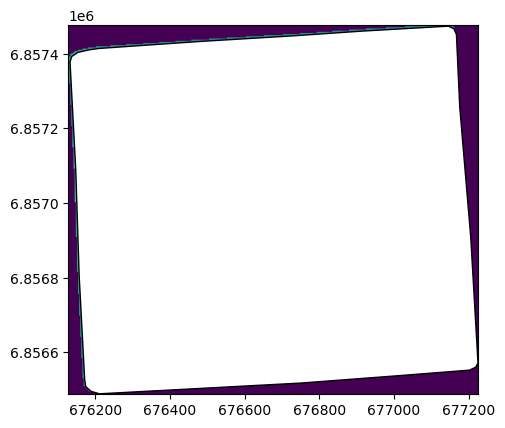

In [216]:
# Open shapefile using geopandas
shp = gpd.read_file(waterbody)

## reading the first tiff file:    
raster_image = rasterio.open(fileList[1])
tiff_band_1 = raster_image.read(1)

print('shapefile CRS: ', shp.crs)
print('image CRS: ', raster_image.crs)

if shp.crs != raster_image.crs:
    print('projections do not match')
    shp = shp.to_crs({'init': 'EPSG:32756'})    
    print('shapefile CRS: ', shp.crs)
    print('image CRS: ', raster_image.crs)
else:
    print('Projections match')
    
# Get raster extent
raster_extent = [raster_image.bounds[0], raster_image.bounds[2], raster_image.bounds[1], raster_image.bounds[3]]

# Create a new plot
f, ax = plt.subplots()

# plot DEM
rasterplot.show(
    tiff_band_1,  # use tiff.read(1) with your data
    extent=raster_extent,
    ax=ax,
)

# plot shapefiles
shp.plot(ax=ax, facecolor='w', edgecolor='k')
plt.savefig('Fix - 20231118-20231204_Planet_Timeseries_Waterbody_NDWI.jpg')
plt.show()

with rasterio.open(fileList[1]) as src:
    #shp=shp.to_crs(src.crs)
    # print(Vector.crs)
    out_image, out_transform=mask(src,shp.geometry,crop=True)
    out_meta=src.meta.copy() # copy the metadata of the source DEM
    
out_meta.update({
    "driver":"Gtiff",
    "height":out_image.shape[1], # height starts with shape[1]
    "width":out_image.shape[2], # width starts with shape[2]
    "transform":out_transform
})

### Loop through images

In [217]:
# Initialize empty DataFrame
df = pd.DataFrame(columns=["Image Name", "Image Date", "Total Area", "NDWI Area", "NDWI Percentage"])

# Get current time
beginNow = datetime.now().strftime("%d/%m/%Y, %H:%M:%S")
print("Starting at " + beginNow)
print("")

# Loop through image folder
for image_file, xml_file in zip(image_files, xml_files):
    image_name = os.path.basename(image)
    image_date = image_name[:8]
    image_date = datetime.strptime(image_date, '%Y%m%d').strftime('%d/%m/%Y')

    print("\nProcessing date: " + image_date)

    print("\nImage name: " + image_name + "\n")

    # create output file name
    clip = folder + "\\" + image_name + "_RGB.tif"  
    # output = folder + "\\" + image_name[:8] + "_NDWI.tif"
    output = folder + "\\" + image_name + "_NDWI.tif"

    # Clip image
    try:
        print("-- Clipping image")
        clip_raster_to_shapefile(image, waterbody, clip)     
    except:      
        print("-- Clipping failed")

    # Create NDWI
    print("-- Calculating NDWI")

    # Load green and NIR bands
    with rasterio.open(clip) as src:
        band_grn = src.read(2).astype(float)
        band_nir = src.read(4).astype(float)

    xmldoc = minidom.parse(xml_file)
    nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

    # XML parser refers to bands by numbers 1-4
    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)

    # Multiply by corresponding coefficients
    print ("Green band coefficient: " , coeffs[2])
    print ("NIR band coefficient: " , coeffs[4])
    #band_grn = band_grn * coeffs[2]
    #band_nir = band_nir * coeffs[4]

    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')

    # Calculate NDWI
    ndwi = (band_grn - band_nir) / (band_grn + band_nir) # McFeeters - Waterbodies

    # Gather statistics
    ndwi_min = np.nanmin(ndwi)
    ndwi_max = np.nanmax(ndwi)
    ndwi_mean = np.nanmean(ndwi)

    print ("-- Generate NDWI statistics")
    print (f"NDWI Minimum: ", ndwi_min)
    print (f"NDWI Maximum: ", ndwi_max)
    print (f"NDWI Mean:   ", ndwi_mean)

    # Set spatial characteristics of the output object to mirror the input
    kwargs = src.meta
    kwargs.update(
    dtype=rasterio.float32,
    count = 1)

    # Write band calculations to a new raster file (values over 0)
    with rasterio.open(output, 'w', **kwargs) as dst:
            dst.write_band(1, ndwi.astype(rasterio.float32))

    # Plot NDWI histogram
    # plot_ndwi_histogram(output)

    # Measure surface area

    print("-- Measuring surface area")

    # Measure areas    
    total_area, area_above_threshold, percentage_above_threshold = measure_area_above_threshold(output, threshold)
    #print("Calculated values:", total_area, area_above_threshold, percentage_above_threshold)
    print("Total Area:", total_area, "square meters")
    print("NDWI Area:", area_above_threshold, "square meters")
    print("NDWI Percentage:", percentage_above_threshold, "%\n")

    # Append results to DataFrame
    new_row = pd.DataFrame({
        "Image Name": [image_name],
        "Image Date": [image_date],
        "Total Area": [total_area],
        "NDWI Area": [area_above_threshold],
        "NDWI Percentage": [percentage_above_threshold]
    })
    df = pd.concat([df, new_row], ignore_index=True)

# Print DataFrame
print(df)

# Save DataFrame to CSV
df.to_csv(csv, index=False)

# Calculate time taken for completion
rightNow = datetime.now().strftime("%d/%m/%Y, %H:%M:%S")
print("Entire period processed, started at " + beginNow + " and finished at " + rightNow)

Starting at 25/07/2024, 12:07:15


Processing date: 18/11/2023

Image name: 20231118_000352_81_2483_3B_AnalyticMS_SR_clip.tif

-- Clipping image
-- Calculating NDWI
Green band coefficient:  1.880356325161028e-05
NIR band coefficient:  3.582184870693599e-05
-- Generate NDWI statistics
NDWI Minimum:  -0.6403220996122875
NDWI Maximum:  0.014095238095238095
NDWI Mean:    -0.38128648523183944
-- Measuring surface area
Pixel size (x, y): 3.0 meters, -3.0 meters
Pixel area:  9.0 m2
Total Area: 968049.0 square meters
NDWI Area: 396.0 square meters
NDWI Percentage: 0.04090702020248975 %


Processing date: 18/11/2023

Image name: 20231118_000352_81_2483_3B_AnalyticMS_SR_clip.tif

-- Clipping image
-- Calculating NDWI
Green band coefficient:  1.8811770765649598e-05
NIR band coefficient:  3.5837484484168335e-05
-- Generate NDWI statistics
NDWI Minimum:  -0.6403220996122875
NDWI Maximum:  0.014095238095238095
NDWI Mean:    -0.38128648523183944
-- Measuring surface area
Pixel size (x, y): 3.0 meters

-- Calculating NDWI
Green band coefficient:  2.0406747636525596e-05
NIR band coefficient:  3.887600539613907e-05
-- Generate NDWI statistics
NDWI Minimum:  -0.6403220996122875
NDWI Maximum:  0.014095238095238095
NDWI Mean:    -0.38128648523183944
-- Measuring surface area
Pixel size (x, y): 3.0 meters, -3.0 meters
Pixel area:  9.0 m2
Total Area: 968049.0 square meters
NDWI Area: 396.0 square meters
NDWI Percentage: 0.04090702020248975 %


Processing date: 18/11/2023

Image name: 20231118_000352_81_2483_3B_AnalyticMS_SR_clip.tif

-- Clipping image
-- Calculating NDWI
Green band coefficient:  1.8536009274031233e-05
NIR band coefficient:  3.531214328687659e-05
-- Generate NDWI statistics
NDWI Minimum:  -0.6403220996122875
NDWI Maximum:  0.014095238095238095
NDWI Mean:    -0.38128648523183944
-- Measuring surface area
Pixel size (x, y): 3.0 meters, -3.0 meters
Pixel area:  9.0 m2
Total Area: 968049.0 square meters
NDWI Area: 396.0 square meters
NDWI Percentage: 0.04090702020248975 %

     